In [1]:
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
from sklearn.decomposition import PCA
import torch
%load_ext autoreload
%autoreload 2

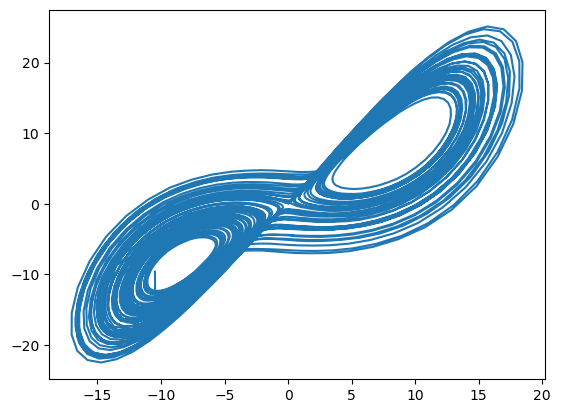

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from dysts.flows import Lorenz, Hadley

## Load and simulate an attractor
model = Lorenz()
sol = model.make_trajectory(5000, resample=True,noise=0.01)
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])


In [4]:
import math
from einops import rearrange, repeat, einsum
class S4D_rnn(nn.Module):
    #produces the A,B,C,D matrices that recapitulate the s4d kernel below
    def __init__(self, d_model, d_state=64, dt_min=0.001, dt_max=0.1, lr=None):
        super().__init__()
        N = d_state
        H = d_model
        log_dt = torch.rand(H) * (
            math.log(dt_max) - math.log(dt_min)
        ) + math.log(dt_min)

        C = torch.randn(H, N // 2, dtype=torch.cfloat)
        self.C = nn.Parameter(torch.view_as_real(C))
        self.register("log_dt", log_dt, lr)

        log_A_real = torch.log(0.5 * torch.ones(H, N//2))
        A_imag = math.pi * repeat(torch.arange(N//2), 'n -> h n', h=H)
        self.register("log_A_real", log_A_real, lr)
        self.register("A_imag", A_imag, lr)
        self.D = nn.Parameter(torch.randn(d_model))

    def register(self, name, tensor, lr=None):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {"weight_decay": 0.0}
            if lr is not None: optim["lr"] = lr
            setattr(getattr(self, name), "_optim", optim)

    def forward(self,u):
        '''input and output shape B,H,L'''
        (b,d_in,l) = u.shape
        dt = torch.exp(self.log_dt) #force dt to be positive
        C = torch.view_as_complex(self.C)
        A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N) , force negative evals     

        dtA = torch.exp(A * dt.unsqueeze(-1))  # (H N)
        C = C * (torch.exp(dtA)-1.) / A

        x = torch.zeros((b, *A.shape), device=u.device)
        self.hiddens = []
        ys = []
        for i in range(u.size(-1)):
            x = einsum(dtA, x, 'h n, b h n -> b h n')
            x += repeat(u[:,:,i],'b d_in -> b d_in h', h=x.shape[-1])
            y = einsum(x, C, 'b d_state h, d_state h -> b d_state').real
            self.hiddens.append(x)
            ys.append(y)

        y = torch.stack(ys, dim=1)  # shape (b, l, d_in)
        self.hiddens = torch.stack(self.hiddens, dim=1)
        y = y + einsum(u,self.D, 'b d_in l, d_state -> b l d_state') 

        return y, self.hiddens


torch.Size([1, 1, 5000])
torch.Size([1, 5000, 1, 250]) torch.Size([1, 5000, 1])
(5000, 250)


/Users/mitchellostrow/opt/anaconda3/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/mitchellostrow/opt/anaconda3/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


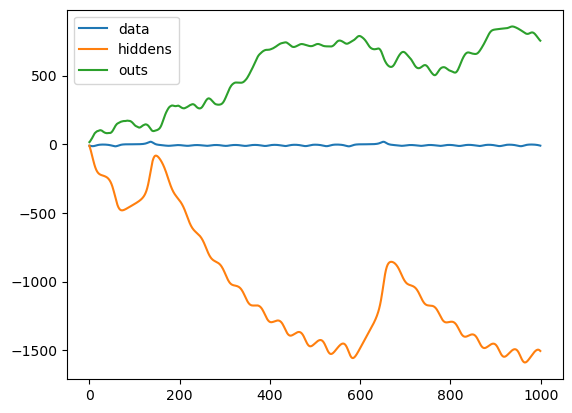

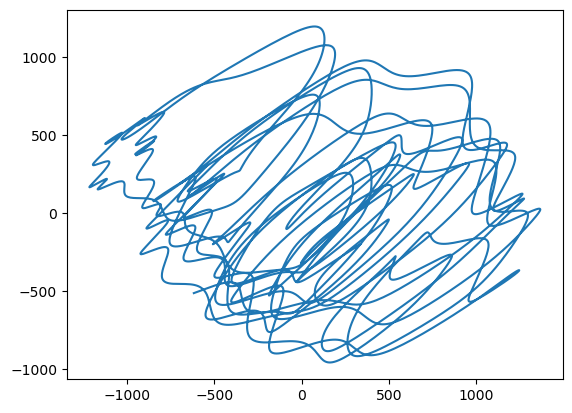

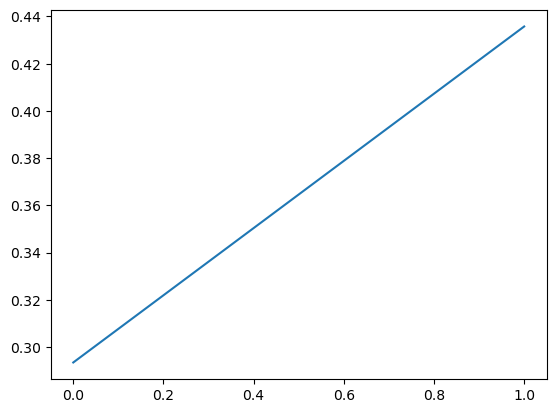

In [6]:
s4rnn = S4D_rnn(1,500)
data = torch.tensor(sol[np.newaxis,:,:1]).float().cpu()
data = data.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
print(data.size())

outs, hiddens = s4rnn(data)
plt.plot(data[0,0,:1000],label="data")
plt.plot(hiddens[0,:1000,0,0].detach().numpy(),label="hiddens")
plt.plot(outs[0,:1000,0].detach().numpy(),label="outs")
plt.legend()
print(hiddens.shape,outs.shape)

hidden = hiddens.squeeze().detach().numpy().real
print(hidden.shape)
pca = PCA(n_components=2)
pca.fit(hidden)
hidden_pca = pca.transform(hidden)
plt.figure()
plt.plot(hidden_pca[:,0],hidden_pca[:,1],label="reconstructed w PCA")
plt.figure()
#plot evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [6]:
class OfficialS4Minimal(nn.Module):
    def __init__(self,d_input,d_output,d_model,d_state,dropout=0.0,prenorm=False,diagonal=True,rnn=False):
        super().__init__()
        self.prenorm = prenorm
        self.encoder = nn.Linear(d_input,d_model)
        s4 = S4 if not diagonal else S4D
        if rnn:
            s4 = S4D_rnn

        self.s4 = s4(d_model,d_state=d_state)

        self.decoder = nn.Linear(d_model,d_output)
        self.norm = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model,4*d_model),
            nn.ReLU(),
            nn.Linear(4*d_model,d_output)
        )

    def forward(self,x):
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)

        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)

        z = x
        if self.prenorm:
            # Prenorm
            z = self.norm(z.transpose(-1, -2)).transpose(-1, -2)

        # Apply S4 block: we ignore the state input and output
        z, _ = self.s4(z)
        print(z.shape, x.shape)

        z = z.transpose(-1, -2)  # (B, d_model, L) -> (B, L, d_model)

        # Residual connection
        x = z + x

        if not self.prenorm:
            # Postnorm
            x = self.norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)

        # Decode the outputs
        x = self.mlp(x)  # (B, d_model) -> (B, d_output)

        return x, None




In [10]:
import sys
sys.path.append('/Users/mitchellostrow/Desktop/Projects/NN_delays/nn_delay_embeddings')
from models import S4
model = S4(1,1,1,500)
model.eval()

torch.Size([1, 5000, 1])
torch.Size([1, 5000, 1]) (500, 5000)


/Users/mitchellostrow/opt/anaconda3/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/mitchellostrow/opt/anaconda3/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


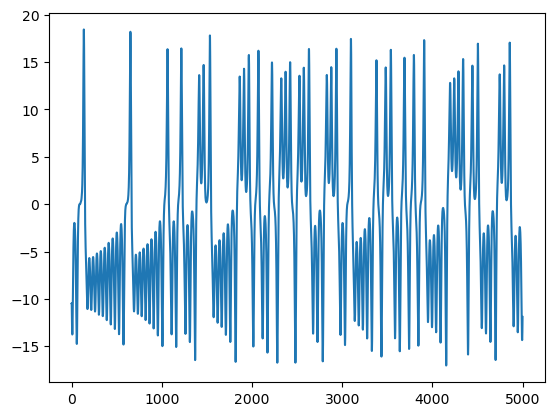

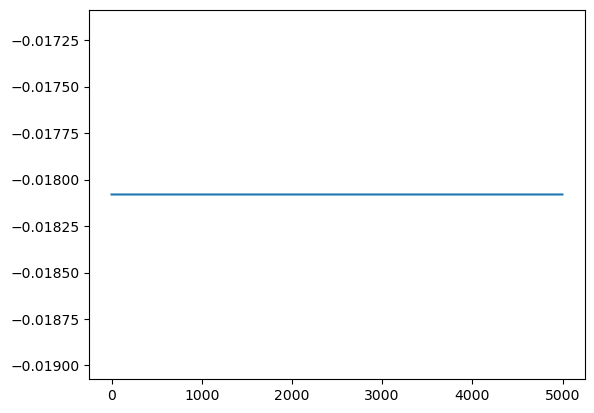

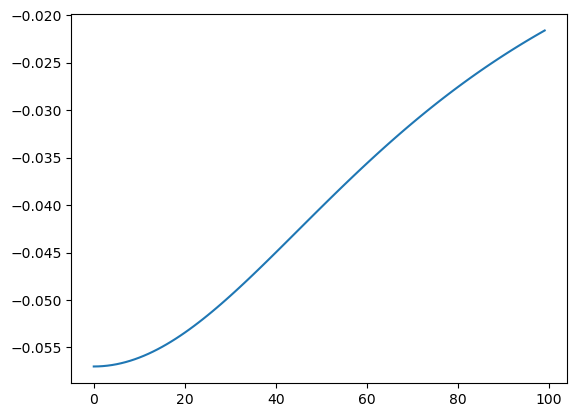

In [13]:
data = torch.tensor(sol[np.newaxis,:,:1]).float()
print(data.size())
plt.figure()
plt.plot(data[0,:,0])


out,hidden = model(data)
hidden = hidden.detach().numpy().squeeze()
print(out.shape, hidden.shape)
plt.figure()
plt.plot(out.detach().numpy()[0,:,0])

plt.figure()
plt.plot(hidden[:100,0])

(500, 5000)


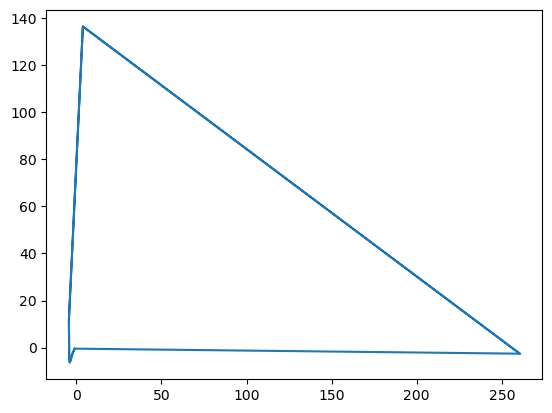

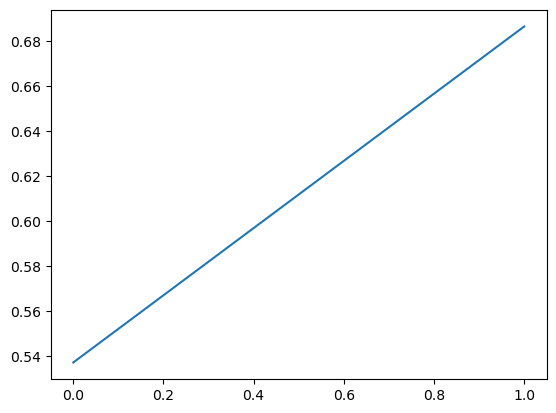

In [14]:
#run pca on the hidden states
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
print(hidden.shape)
hidden_pca = pca.fit_transform(hidden.real)
plt.figure()
plt.plot(hidden_pca[:,0],hidden_pca[:,1])
plt.figure()
#plot evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [15]:
from utils import make_dataset,train

train_loader, val_loader, train_data, val_data = make_dataset(Lorenz,2000,10)


(10, 2000, 3) torch.Size([10, 2000, 1])
(10, 2000, 3) torch.Size([10, 2000, 1])


In [19]:
from torch.optim import AdamW

model = S4(1,1,10,100,dropout=0.01,prenorm=True,noC=True)

#model,train_set,val_set,epochs,lr,optimizer,loss_fn,device
all_train_loss = []
all_val_loss = []
device = 'cpu'
for num_steps in [1,3]:
    model, train_loss, val_loss = train(model, train_loader, val_loader, 50, 1e-2,AdamW, nn.MSELoss(), device,num_steps)
    model, train_loss, val_loss = train(model, train_loader, val_loader, 50, 1e-3,AdamW, nn.MSELoss(), device,num_steps)
    all_train_loss.extend(train_loss)
    all_val_loss.extend(val_loss)

plt.plot(all_train_loss)
plt.plot(all_val_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 Training Loss: 568848.6353378296


  2%|▏         | 1/50 [00:15<12:44, 15.60s/it]

Epoch 0 Validation Loss: 63.74841232299805


torch.Size([1, 5000, 1])
torch.Size([1, 5000, 1]) torch.Size([1, 1, 5000])
torch.Size([1, 5000, 1]) (5000, 500)
(5000, 500)


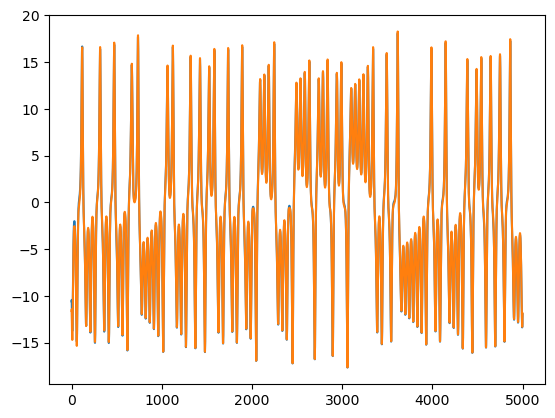

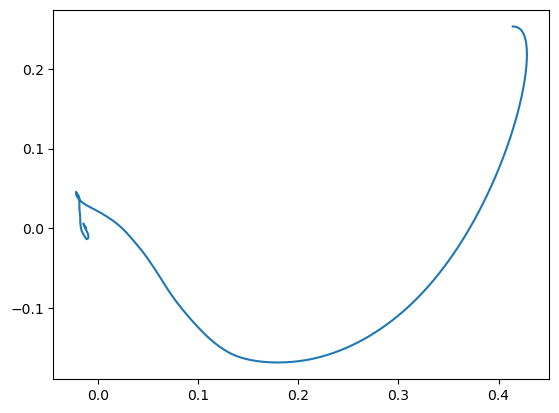

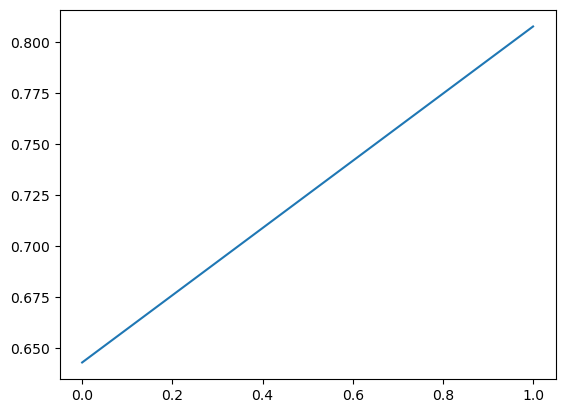

In [93]:
data = torch.tensor(sol[np.newaxis,:,:1]).float().cuda()
print(data.size())
plt.figure()
plt.plot(data[0,:,0].cpu())


out,_ = model(data)
hidden = model.s4.hiddens.detach().cpu().numpy().squeeze()
print(out.shape, hidden.shape)
plt.plot(out.detach().cpu().numpy()[0,:,0])

#run pca on the hidden states
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
print(hidden.shape)
hidden_pca = pca.fit_transform(hidden.real)
plt.figure()
plt.plot(hidden_pca[:,0],hidden_pca[:,1])
plt.figure()
#plot evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
def hippo_initializer(dim):
    pass

def discretize_dplr(lambd,P,Q,B,C,step,l_max):
    pass

def scan_ssm(ssm,u,x0):
    pass

class minimalS4(nn.Module):
    def __init__(self, input_dim,d_model,n_head):
        super().__init__()

        
